In [114]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from lazypredict.Supervised import LazyClassifier
import joblib
import os
from lightning import seed_everything
from utils import SEED
import pytorch_lightning as pl
import torch
from torch import nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
import torch
import torch.nn.functional as F
from lazypredict.Supervised import LazyClassifier
from torch.utils.data import Dataset, DataLoader

## Methods

In [115]:
def set_seed(seed=SEED):
    seed_everything(seed)

# Load dataset from pickle file
def read_pickle(filename: str) -> pd.DataFrame:
    with open(filename, 'rb') as f:
        return pd.DataFrame(pickle.load(f))

# Perform t-SNE dimensionality reduction
def apply_tsne(dataset_train):
    tsne = TSNE(n_components=2, random_state=0, perplexity=min(30, len(dataset_train["sample"])-1), n_iter=1000)
    return tsne.fit_transform(np.array(dataset_train["sample"].to_list()))

def apply_tsne_to_numpy(X):
    tsne = TSNE(n_components=2, random_state=0, perplexity=min(30, len(X)-1), n_iter=1000)
    return tsne.fit_transform(X)

# Plot t-SNE scatter plot
def plot_tsne(X_2d, labels):
    colors = ['red', 'blue']
    plt.figure(figsize=(8, 6))
    for i in range(len(X_2d)):
        plt.scatter(X_2d[i, 0], X_2d[i, 1], color=colors[labels[i]], s=15, alpha=0.7, edgecolor='k')
    plt.legend(['Class 0', 'Class 1'], loc='upper right', fontsize=10, frameon=True)
    plt.title("t-SNE Representation", fontsize=14)
    plt.xlabel("t-SNE Component 1", fontsize=12)
    plt.ylabel("t-SNE Component 2", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# Plot label distribution as a histogram
def plot_label_distribution(label_counts, title="Distribution of Labels"):
    colors = ['blue', 'red']
    plt.figure(figsize=(8, 6))
    plt.bar(label_counts.index, label_counts.values, color=colors, alpha=0.85, edgecolor='black', linewidth=1.2)
    plt.title(title, fontsize=14)
    plt.xlabel("Labels", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.xticks([0, 1], ['Class 0', 'Class 1'], fontsize=10)
    for i, value in enumerate(label_counts.values):
        plt.text(i, value + 0.5, str(value), ha='center', fontsize=10, color='black')
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# Balance the dataset by downsampling the majority class
def balance_dataset(dataset_train):
    class_majority = dataset_train[dataset_train['label'] == 0]
    class_minority = dataset_train[dataset_train['label'] == 1]
    class_majority_downsampled = class_majority.sample(n=len(class_minority), random_state=42)
    df_balanced = pd.concat([class_majority_downsampled, class_minority])
    return df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Train and evaluate models using LazyClassifier
def lazy_classification(X_train, X_test, y_train, y_test):
    clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
    models, _ = clf.fit(X_train, X_test, y_train, y_test)
    return models

def save_predictions_to_csv(predictions, folder=None, filename="clf_models.csv"):
    assert folder is not None, "Please provide a folder to save the predictions."
    predictions_df = pd.DataFrame(predictions)
    file_path = os.path.join(folder, filename)
    predictions_df.to_csv(file_path, index=True, sep=';')
    print(f"Predictions saved to {file_path}")

# Optimize and evaluate models using RandomizedSearchCV
def optimize_models(X_train, y_train, X_test, y_test):
    models = {
        "RandomForest": (RandomForestClassifier(n_jobs=-1), {
            "n_estimators": [50, 100, 200],
            "max_depth": [None, 10, 20, 30],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4],
            "bootstrap": [True, False]
        }),
    }
    best_models = {}
    for model_name, (model, param_grid) in models.items():
        print(f"\nOptimizing {model_name}...")
        grid_search = RandomizedSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        print(f"Best parameters for {model_name}: {grid_search.best_params_}")
        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)
        print(f"Classification report for {model_name}:\n{classification_report(y_test, y_pred)}")
        best_models[model_name] = best_model
    return best_models

# Save the best model to a file
def save_model(best_models, model_name, folder="models"):
    os.makedirs(folder, exist_ok=True)
    if model_name in best_models:
        file_path = os.path.join(folder, f"{model_name}_best_model.pkl")
        joblib.dump(best_models[model_name], file_path)
        print(f"Model {model_name} saved as {file_path}")
    else:
        print(f"Model {model_name} not found in best_models.")

In [116]:
def experiments(dataset_train, dataset_test, dataset_train_path):
    plot_label_distribution(dataset_train['label'].value_counts())

    df_balanced = balance_dataset(dataset_train)
    plot_label_distribution(df_balanced['label'].value_counts(), title="Balanced Distribution of Labels")

    #X_2d = apply_tsne(df_balanced)
    #plot_tsne(X_2d, df_balanced['label'].to_list())

    X_train = np.array(df_balanced["sample"].to_list())
    y_train = np.array(df_balanced["label"].to_list())
    X_test = np.array(dataset_test["sample"].to_list())
    y_test = np.array(dataset_test["label"].to_list())

    models = lazy_classification(X_train, X_test, y_train, y_test)
    folder_to_save = "/".join([f for f in dataset_train_path.split("/")[:-1]])
    save_predictions_to_csv(models, folder=folder_to_save)

    print("#"*50)
    print(models.head(5))

In [117]:
set_seed()

Seed set to 3407


## Autoencoders

In [56]:
class Autoencoder(pl.LightningModule):

    def __init__(self):
        super(Autoencoder, self).__init__()

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    def features(self, x):
        encoded = self.encoder(x)
        return encoded

    def training_step(self, batch, batch_idx):
        x, _ = batch
        x_hat = self(x)
        loss = nn.MSELoss()(x_hat, x)
        self.log('train_loss', loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, _ = batch
        x_hat = self(x)
        loss = nn.MSELoss()(x_hat, x)
        self.log('val_loss', loss, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, _ = batch
        x_hat = self(x)
        loss = nn.MSELoss()(x_hat, x)
        self.log('test_loss', loss, prog_bar=True)
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

def contrastive_loss(latents, labels, margin=1.0):
    # latents: Representaciones latentes de tamaño [batch_size, latent_dim]
    # labels: Etiquetas de las muestras en el batch [batch_size]
    batch_size = latents.size(0)
    loss = 0.0

    for i in range(batch_size):
        for j in range(batch_size):
            if i != j:
                distance = F.pairwise_distance(latents[i].unsqueeze(0), latents[j].unsqueeze(0))
                if labels[i] == labels[j]:  # Mismas clases
                    loss += distance**2
                else:  # Clases diferentes
                    loss += torch.clamp(margin - distance, min=0)**2

    return loss / (batch_size * (batch_size - 1))

class LinearAutoencoder(Autoencoder):
    def __init__(self, input_dim: int):
        super(LinearAutoencoder, self).__init__()
        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
        )

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim),
        )

class LinearAutoencoderContrastive(LinearAutoencoder):

    def __init__(self, input_dim: int, _lambda: float = 0.1):
        super(LinearAutoencoderContrastive, self).__init__(input_dim)
        self.lambda_ = _lambda

    def training_step(self, batch, batch_idx):
        x, labels = batch
        latents = self.features(x)
        x_hat = self(x)

        reconstruction_loss = nn.MSELoss()(x_hat, x)
        clustering_loss = contrastive_loss(latents, labels)

        total_loss = reconstruction_loss + self.lambda_ * clustering_loss  # Ajusta el peso
        self.log('train_loss', total_loss, prog_bar=True)
        self.log('reconstruction_loss', reconstruction_loss, prog_bar=True)
        self.log('clustering_loss', clustering_loss, prog_bar=True)
        return total_loss
    
    def validation_step(self, batch, batch_idx):
        x, labels = batch
        latents = self.features(x)
        x_hat = self(x)

        reconstruction_loss = nn.MSELoss()(x_hat, x)
        clustering_loss = contrastive_loss(latents, labels)

        total_loss = reconstruction_loss + self.lambda_ * clustering_loss
        self.log('val_loss', total_loss, prog_bar=True)
        self.log('reconstruction_loss', reconstruction_loss, prog_bar=True)
        self.log('clustering_loss', clustering_loss, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, labels = batch
        latents = self.features(x)
        x_hat = self(x)

        reconstruction_loss = nn.MSELoss()(x_hat, x)
        clustering_loss = contrastive_loss(latents, labels)

        total_loss = reconstruction_loss + self.lambda_ * clustering_loss
        self.log('test_loss', total_loss, prog_bar=True)
        self.log('reconstruction_loss', reconstruction_loss, prog_bar=True)
        self.log('clustering_loss', clustering_loss, prog_bar=True)


# dataloaders
class AutoencoderDataset(Dataset):
    def __init__(self, dataframe):
        self.samples = torch.tensor(dataframe['sample'].values.tolist(), dtype=torch.float32)
        self.labels = torch.tensor(dataframe['label'].values.tolist(), dtype=torch.float32)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx], self.labels[idx]

# Create DataLoader for training, validation, and testing
def create_data_loaders(dataframe_train, dataframe_val, dataframe_test, batch_size=64):
    train_dataset = AutoencoderDataset(dataframe_train)
    val_dataset = AutoencoderDataset(dataframe_val)
    test_dataset = AutoencoderDataset(dataframe_test)

    # Creating DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader




In [68]:
def experiments_autoencoders(dataset_train, dataset_test, dataset_val, dataset_train_path, autoencoder_type = "linear"):
    plot_label_distribution(dataset_train['label'].value_counts())

    df_balanced = balance_dataset(dataset_train)
    plot_label_distribution(df_balanced['label'].value_counts(), title="Balanced Distribution of Labels")
    train_loader, val_loader, test_loader = create_data_loaders(df_balanced, dataset_val, dataset_test, batch_size=64)
    input_dim = len(dataset_train["sample"][0])

    autoencoder = LinearAutoencoder(input_dim=input_dim) if autoencoder_type == "linear" else LinearAutoencoderContrastive(input_dim=input_dim)

    trainer = pl.Trainer(max_epochs=10)
    trainer.fit(autoencoder, train_loader, val_loader)

    # Test the model
    print("Test autoencoder")
    trainer.test(autoencoder, test_loader)

    X_train = autoencoder.features(torch.tensor(df_balanced["sample"].values.tolist(), dtype=torch.float32)).detach().numpy()
    y_train = np.array(dataset_train["label"].values.tolist())

    X_test = autoencoder.features(torch.tensor(dataset_test["sample"].values.tolist(), dtype=torch.float32)).detach().numpy()
    y_test = np.array(dataset_test["label"].values.tolist())

    
    #X_2d = apply_tsne_to_numpy(X_train)
    #plot_tsne(X_2d, y_train)

    models = lazy_classification(X_train, X_test, y_train, y_test)
    folder_to_save = "/".join([f for f in dataset_train_path.split("/")[:-1]])
    save_predictions_to_csv(models, folder=folder_to_save)

    print("#"*50)
    print(models.head(5))
    

## Chunks embeddings OpenIA

In [119]:
dataset_train_path = "data/04-clustering/spanish-chunks-openai/clustring_embedding_train.pkl"
dataset_val_path = "data/04-clustering/spanish-chunks-openai/clustring_embedding_validation.pkl"
dataset_test_path = "data/04-clustering/spanish-chunks-openai/clustring_embedding_test.pkl"

dataset_train = read_pickle(dataset_train_path)
dataset_val = read_pickle(dataset_val_path)
# sum dataset_train and dataset_val into dataset_train
dataset_train = pd.concat([dataset_train, dataset_val], ignore_index=True)
dataset_test = read_pickle(dataset_test_path)

In [106]:
df_balanced = balance_dataset(dataset_train)
train_loader, val_loader, test_loader = create_data_loaders(df_balanced, dataset_val, dataset_test, batch_size=64)

In [107]:
input_dim = len(dataset_train["sample"][0])

In [108]:
linear_autoencoder = LinearAutoencoderContrastive(input_dim=input_dim)

In [109]:
trainer = pl.Trainer(max_epochs=10)
trainer.fit(linear_autoencoder, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | encoder | Sequential | 1.6 M  | train
1 | decoder | Sequential | 1.6 M  | train
-----------------------------------------------
3.3 M     Trainable params
0         Non-trainable params
3.3 M     Total params
13.124    Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 76/76 [01:40<00:00,  0.75it/s, v_num=32, train_loss=0.0108, reconstruction_loss=0.000111, clustering_loss=0.286, val_loss=0.0287]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 76/76 [01:41<00:00,  0.75it/s, v_num=32, train_loss=0.0108, reconstruction_loss=0.000111, clustering_loss=0.286, val_loss=0.0287]


In [110]:
print("Test MLP")
trainer.test(linear_autoencoder, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Test MLP
Testing DataLoader 0: 100%|██████████| 37/37 [00:15<00:00,  2.39it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      clustering_loss      │    0.29508158564567566    │
│    reconstruction_loss    │  0.00011342252400936559   │
│         test_loss         │   0.029621588066220284    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.029621588066220284,
  'reconstruction_loss': 0.00011342252400936559,
  'clustering_loss': 0.29508158564567566}]

In [111]:
# transform data using the encoder part of the autoencoder
X_train = linear_autoencoder.features(torch.tensor(df_balanced["sample"].values.tolist(), dtype=torch.float32)).detach().numpy()
y_train = np.array(df_balanced["label"].values.tolist())

X_test = linear_autoencoder.features(torch.tensor(dataset_test["sample"].values.tolist(), dtype=torch.float32)).detach().numpy()
y_test = np.array(dataset_test["label"].values.tolist())

In [112]:
print(X_train.shape)
print(y_train.shape)

(4806, 128)
(4806,)


In [113]:
# clf
clf = LazyClassifier(verbose=1, ignore_warnings=True, custom_metric=None)
models, pred = clf.fit(X_train, X_test, y_train, y_test)

  3%|▎         | 1/31 [00:02<01:21,  2.73s/it]

{'Model': 'AdaBoostClassifier', 'Accuracy': 0.6248937977909941, 'Balanced Accuracy': 0.6864570350366985, 'ROC AUC': 0.6864570350366985, 'F1 Score': 0.6589530720180252, 'Time taken': 2.730456590652466}


  6%|▋         | 2/31 [00:06<01:44,  3.61s/it]

{'Model': 'BaggingClassifier', 'Accuracy': 0.64910790144435, 'Balanced Accuracy': 0.6974049214097771, 'ROC AUC': 0.697404921409777, 'F1 Score': 0.6812454210757998, 'Time taken': 4.221425771713257}
{'Model': 'BernoulliNB', 'Accuracy': 0.6308411214953271, 'Balanced Accuracy': 0.6836170111480404, 'ROC AUC': 0.6836170111480405, 'F1 Score': 0.6645729749881458, 'Time taken': 0.028232336044311523}


 13%|█▎        | 4/31 [00:07<00:39,  1.47s/it]

{'Model': 'CalibratedClassifierCV', 'Accuracy': 0.6482582837723024, 'Balanced Accuracy': 0.6968661283063288, 'ROC AUC': 0.6968661283063288, 'F1 Score': 0.6804740137678089, 'Time taken': 0.363936185836792}


 19%|█▉        | 6/31 [00:07<00:23,  1.09it/s]

{'Model': 'DecisionTreeClassifier', 'Accuracy': 0.6295666949872557, 'Balanced Accuracy': 0.6791357239302036, 'ROC AUC': 0.6791357239302036, 'F1 Score': 0.6634438776816615, 'Time taken': 0.6057698726654053}
{'Model': 'DummyClassifier', 'Accuracy': 0.7884451996601529, 'Balanced Accuracy': 0.5, 'ROC AUC': 0.5, 'F1 Score': 0.6951801855435837, 'Time taken': 0.012837409973144531}
{'Model': 'ExtraTreeClassifier', 'Accuracy': 0.627017841971113, 'Balanced Accuracy': 0.6738462470571942, 'ROC AUC': 0.6738462470571942, 'F1 Score': 0.6611418206222544, 'Time taken': 0.018166303634643555}


 29%|██▉       | 9/31 [00:08<00:11,  1.92it/s]

{'Model': 'ExtraTreesClassifier', 'Accuracy': 0.6308411214953271, 'Balanced Accuracy': 0.686555489198172, 'ROC AUC': 0.6865554891981721, 'F1 Score': 0.6645322442126335, 'Time taken': 0.3382415771484375}
{'Model': 'GaussianNB', 'Accuracy': 0.6316907391673747, 'Balanced Accuracy': 0.6826865652264229, 'ROC AUC': 0.6826865652264229, 'F1 Score': 0.6653699626908324, 'Time taken': 0.01884603500366211}
{'Model': 'KNeighborsClassifier', 'Accuracy': 0.632965165675446, 'Balanced Accuracy': 0.6981871451322532, 'ROC AUC': 0.6981871451322532, 'F1 Score': 0.6663001545289641, 'Time taken': 0.03776979446411133}


 42%|████▏     | 13/31 [00:08<00:05,  3.24it/s]

{'Model': 'LabelPropagation', 'Accuracy': 0.7867459643160578, 'Balanced Accuracy': 0.5003916528181692, 'ROC AUC': 0.5003916528181693, 'F1 Score': 0.6959244496258371, 'Time taken': 0.2927727699279785}


 52%|█████▏    | 16/31 [00:09<00:03,  3.81it/s]

{'Model': 'LabelSpreading', 'Accuracy': 0.7867459643160578, 'Balanced Accuracy': 0.5003916528181692, 'ROC AUC': 0.5003916528181693, 'F1 Score': 0.6959244496258371, 'Time taken': 0.4859919548034668}
{'Model': 'LinearDiscriminantAnalysis', 'Accuracy': 0.6257434154630417, 'Balanced Accuracy': 0.6914035452153442, 'ROC AUC': 0.6914035452153442, 'F1 Score': 0.6596308906171285, 'Time taken': 0.09169363975524902}
{'Model': 'LinearSVC', 'Accuracy': 0.64910790144435, 'Balanced Accuracy': 0.6974049214097771, 'ROC AUC': 0.697404921409777, 'F1 Score': 0.6812454210757998, 'Time taken': 0.09314703941345215}


 58%|█████▊    | 18/31 [00:09<00:02,  4.93it/s]

{'Model': 'LogisticRegression', 'Accuracy': 0.6457094307561597, 'Balanced Accuracy': 0.6989228465586483, 'ROC AUC': 0.6989228465586484, 'F1 Score': 0.6781432606625392, 'Time taken': 0.04296398162841797}
{'Model': 'NearestCentroid', 'Accuracy': 0.6261682242990654, 'Balanced Accuracy': 0.6791844100540092, 'ROC AUC': 0.6791844100540092, 'F1 Score': 0.66029143411894, 'Time taken': 0.07953691482543945}


 61%|██████▏   | 19/31 [00:10<00:03,  3.52it/s]

{'Model': 'NuSVC', 'Accuracy': 0.6257434154630417, 'Balanced Accuracy': 0.678915013502285, 'ROC AUC': 0.678915013502285, 'F1 Score': 0.6598997780797814, 'Time taken': 0.6633288860321045}
{'Model': 'PassiveAggressiveClassifier', 'Accuracy': 0.7132540356839422, 'Balanced Accuracy': 0.6793142397174907, 'ROC AUC': 0.6793142397174907, 'F1 Score': 0.7337175356284306, 'Time taken': 0.030863523483276367}
{'Model': 'Perceptron', 'Accuracy': 0.6406117247238743, 'Balanced Accuracy': 0.6934862294003601, 'ROC AUC': 0.6934862294003601, 'F1 Score': 0.6734978333109175, 'Time taken': 0.026034116744995117}
{'Model': 'QuadraticDiscriminantAnalysis', 'Accuracy': 0.6253186066270179, 'Balanced Accuracy': 0.6933380072012187, 'ROC AUC': 0.6933380072012187, 'F1 Score': 0.6591705601854629, 'Time taken': 0.040767669677734375}


 74%|███████▍  | 23/31 [00:13<00:04,  1.90it/s]

{'Model': 'RandomForestClassifier', 'Accuracy': 0.637213254035684, 'Balanced Accuracy': 0.6928002960116327, 'ROC AUC': 0.6928002960116327, 'F1 Score': 0.6703672811253761, 'Time taken': 2.981943368911743}
{'Model': 'RidgeClassifier', 'Accuracy': 0.6274426508071368, 'Balanced Accuracy': 0.6939503704473065, 'ROC AUC': 0.6939503704473065, 'F1 Score': 0.6611762668231803, 'Time taken': 0.026474475860595703}


 81%|████████  | 25/31 [00:13<00:02,  2.35it/s]

{'Model': 'RidgeClassifierCV', 'Accuracy': 0.6248937977909941, 'Balanced Accuracy': 0.6915993716244287, 'ROC AUC': 0.6915993716244287, 'F1 Score': 0.6588166467358576, 'Time taken': 0.2537271976470947}
{'Model': 'SGDClassifier', 'Accuracy': 0.6083262531860663, 'Balanced Accuracy': 0.6612581792687994, 'ROC AUC': 0.6612581792687994, 'F1 Score': 0.6438990074950289, 'Time taken': 0.06995773315429688}


 87%|████████▋ | 27/31 [00:13<00:01,  2.84it/s]

{'Model': 'SVC', 'Accuracy': 0.6304163126593033, 'Balanced Accuracy': 0.6892245706965794, 'ROC AUC': 0.6892245706965794, 'F1 Score': 0.6640903863229315, 'Time taken': 0.23930072784423828}


100%|██████████| 31/31 [00:14<00:00,  2.16it/s]

{'Model': 'XGBClassifier', 'Accuracy': 0.6325403568394222, 'Balanced Accuracy': 0.6927754119927988, 'ROC AUC': 0.6927754119927988, 'F1 Score': 0.6660140916786688, 'Time taken': 0.37741827964782715}
[LightGBM] [Info] Number of positive: 2403, number of negative: 2403
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001635 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32640
[LightGBM] [Info] Number of data points in the train set: 4806, number of used features: 128
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
{'Model': 'LGBMClassifier', 'Accuracy': 0.6282922684791844, 'Balanced Accuracy': 0.6886122074504917, 'ROC AUC': 0.6886122074504917, 'F1 Score': 0.6621089310454515, 'Time taken': 0.14985108375549316}


In [104]:
print(models)

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
NuSVC                              0.64               0.70     0.70      0.67   
SVC                                0.63               0.69     0.69      0.66   
ExtraTreesClassifier               0.64               0.69     0.69      0.68   
LGBMClassifier                     0.63               0.69     0.69      0.67   
RandomForestClassifier             0.66               0.68     0.68      0.69   
QuadraticDiscriminantAnalysis      0.54               0.67     0.67      0.57   
XGBClassifier                      0.63               0.67     0.67      0.66   
AdaBoostClassifier                 0.59               0.66     0.66      0.63   
LinearDiscriminantAnalysis         0.66               0.66     0.66      0.69   
RidgeClassifierCV                  0.66               0.65     0.65      0.69   
RidgeClassifier             

In [64]:
# tsne
X_2d = apply_tsne_to_numpy(X_train)

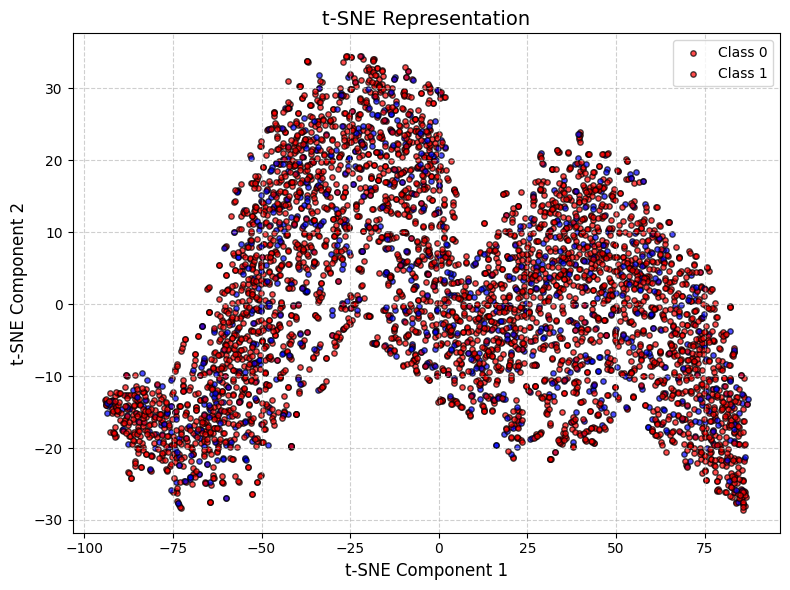

In [65]:
# plot
plot_tsne(X_2d, y_train)

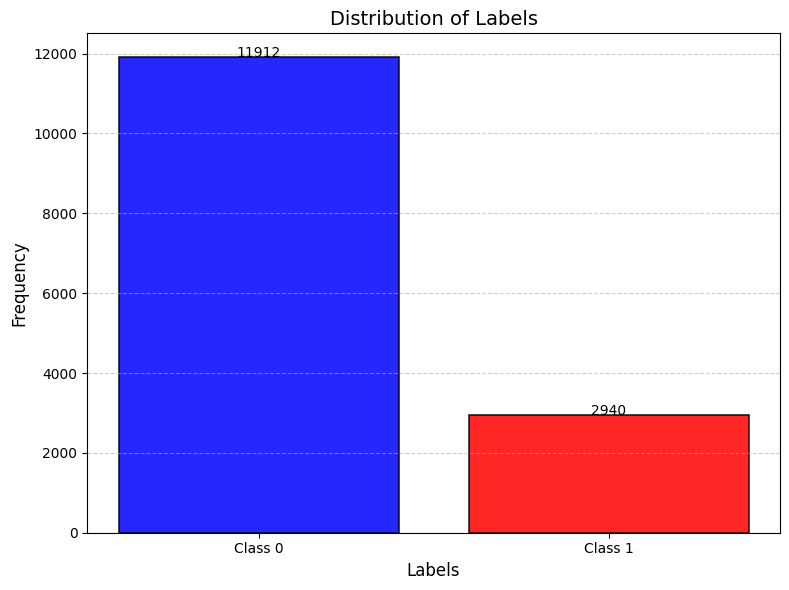

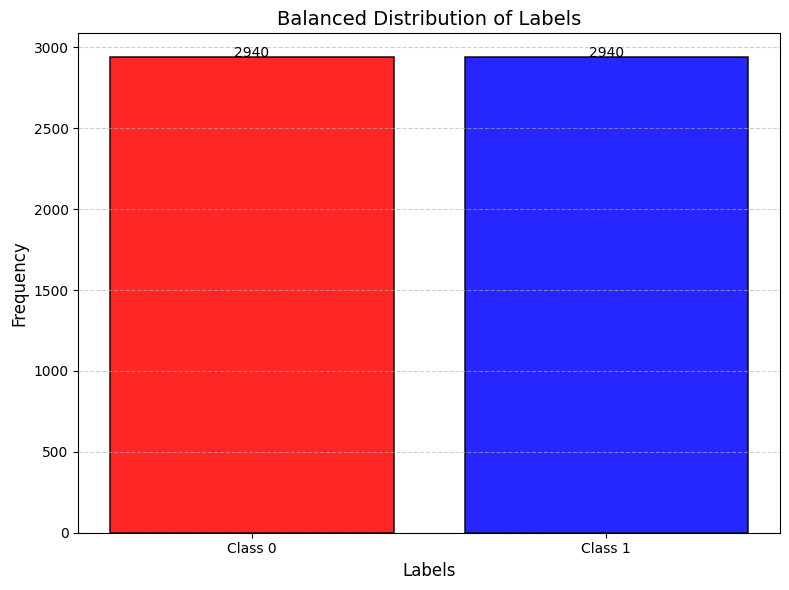

 97%|█████████▋| 30/31 [30:51<00:20, 20.84s/it]  

[LightGBM] [Info] Number of positive: 2940, number of negative: 2940
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091212 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 783360
[LightGBM] [Info] Number of data points in the train set: 5880, number of used features: 3072
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


100%|██████████| 31/31 [30:56<00:00, 59.89s/it]

Predictions saved to data/04-clustering/spanish-chunks-openai/clf_models.csv
##################################################
                      Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                  
NuSVC                     0.67               0.73     0.73      0.70   
SVC                       0.66               0.73     0.73      0.69   
LGBMClassifier            0.64               0.70     0.70      0.67   
XGBClassifier             0.64               0.70     0.70      0.68   
ExtraTreesClassifier      0.63               0.70     0.70      0.67   

                      Time Taken  
Model                             
NuSVC                      49.71  
SVC                        44.43  
LGBMClassifier              5.36  
XGBClassifier              43.94  
ExtraTreesClassifier        5.82  


In [120]:
experiments(dataset_train, dataset_test, dataset_train_path)

## Chunks MNLI

In [67]:
dataset_train_path = "data/04-clustering/spanish-chunks-sentence-transformers/clustring_embedding_train.pkl"
dataset_test_path = "data/04-clustering/spanish-chunks-sentence-transformers/clustring_embedding_test.pkl"
dataset_train = read_pickle(dataset_train_path)
dataset_test = read_pickle(dataset_test_path)

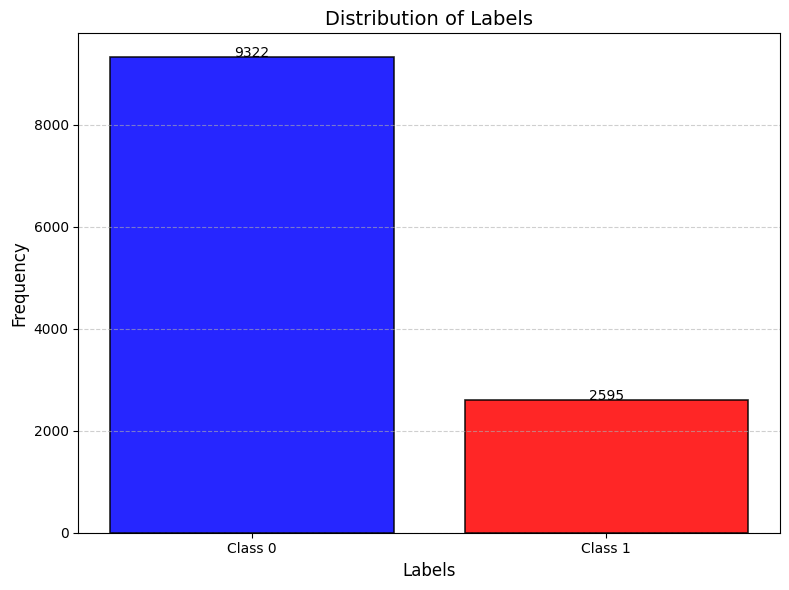

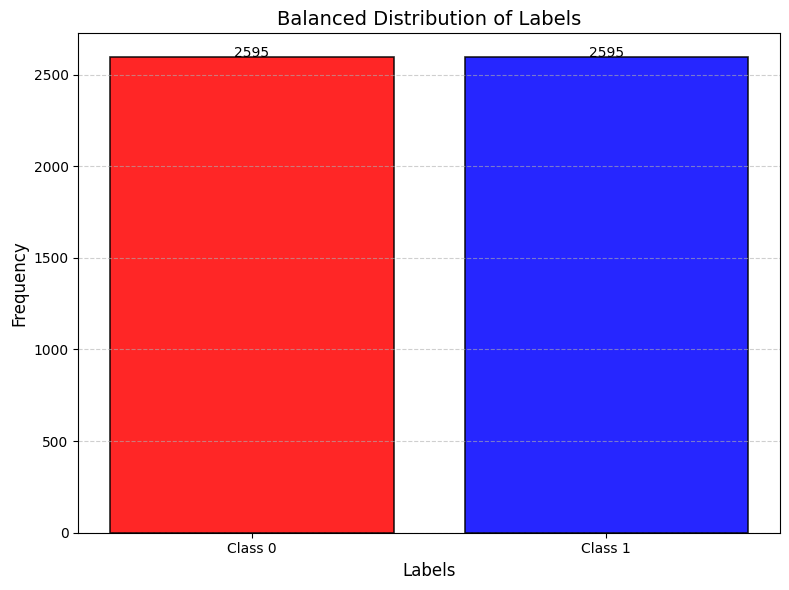

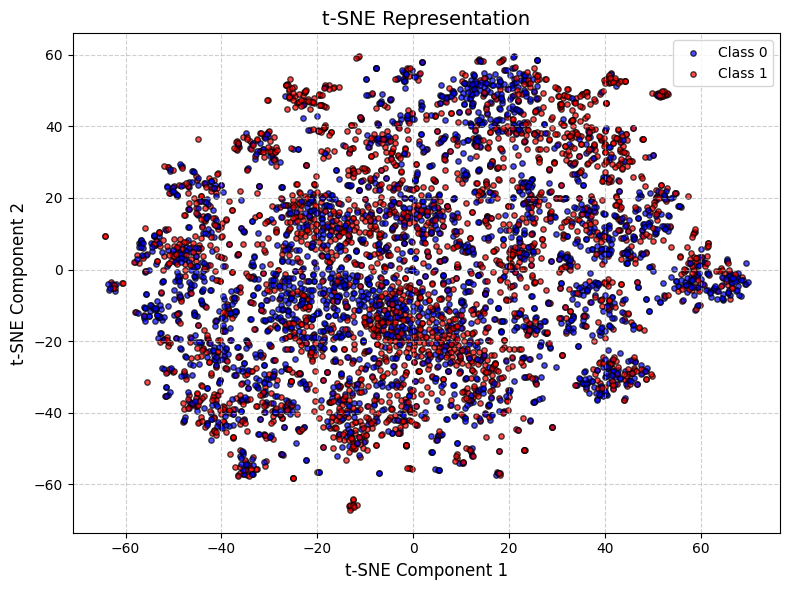

 97%|█████████▋| 30/31 [01:51<00:01,  1.88s/it]

[LightGBM] [Info] Number of positive: 2595, number of negative: 2595
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012476 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 5190, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


100%|██████████| 31/31 [01:52<00:00,  3.64s/it]

Predictions saved to data/04-clustering/spanish-chunks-sentence-transformers/clf_models.csv
##################################################
                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
SVC                                0.63               0.68     0.68      0.65   
ExtraTreesClassifier               0.64               0.68     0.68      0.67   
QuadraticDiscriminantAnalysis      0.63               0.67     0.67      0.65   
RandomForestClassifier             0.65               0.67     0.67      0.67   
LGBMClassifier                     0.63               0.67     0.67      0.65   

                               Time Taken  
Model                                      
SVC                                  6.87  
ExtraTreesClassifier                 1.46  
QuadraticDiscriminantAnalysis        0.48  
RandomForestClassifier               9.64  
LGBMClassifier           

In [68]:
experiments(dataset_train, dataset_test, dataset_train_path)

## spanish-paragraphs-openai

In [69]:
dataset_train_path = "data/04-clustering/spanish-paragraphs-openai/clustring_embedding_train.pkl"
dataset_test_path = "data/04-clustering/spanish-paragraphs-openai/clustring_embedding_test.pkl"
dataset_train = read_pickle(dataset_train_path)
dataset_test = read_pickle(dataset_test_path)

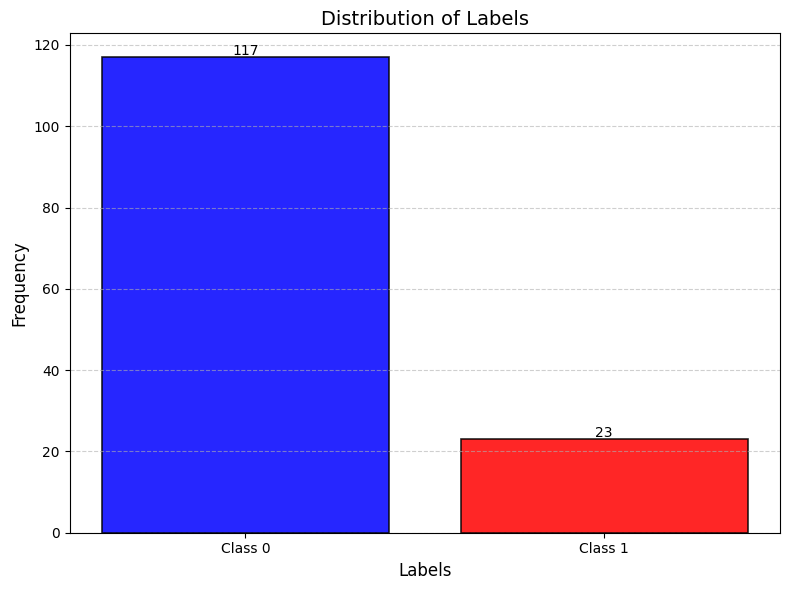

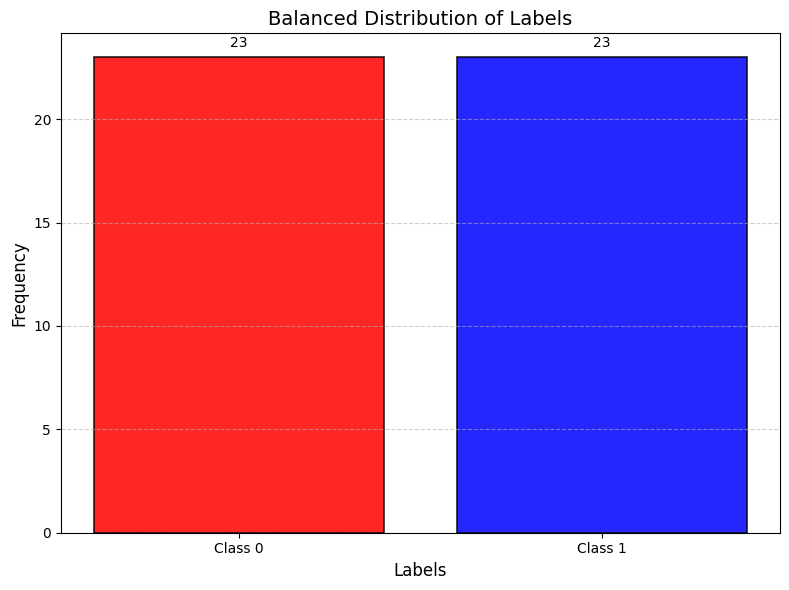

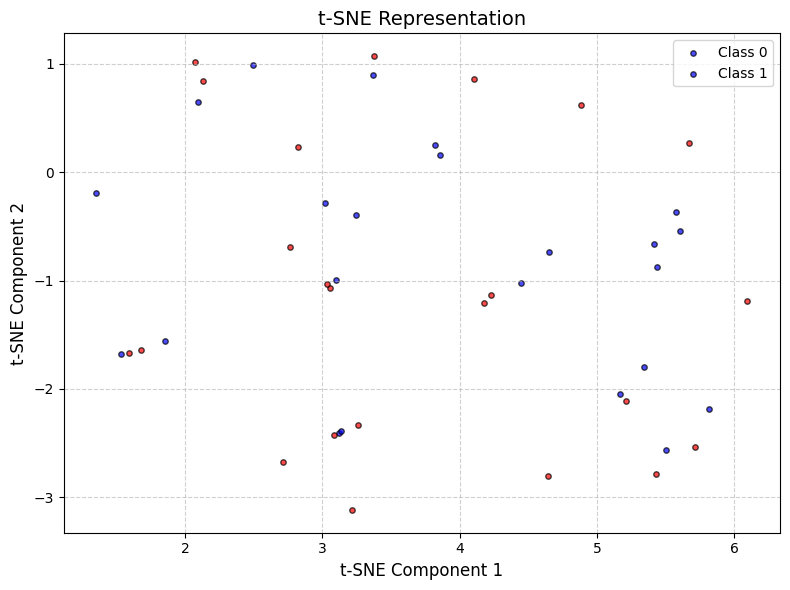

100%|██████████| 31/31 [00:02<00:00, 13.21it/s]

[LightGBM] [Info] Number of positive: 23, number of negative: 23
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002410 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 52224
[LightGBM] [Info] Number of data points in the train set: 46, number of used features: 3072
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

In [200]:
experiments(dataset_train, dataset_test, dataset_train_path)

## spanish-paragraphs-sentence-transformers

In [201]:
dataset_train_path = "data/04-clustering/spanish-paragraphs-sentence-transformers/clustring_embedding_train.pkl"
dataset_test_path = "data/04-clustering/spanish-paragraphs-sentence-transformers/clustring_embedding_test.pkl"
dataset_train = read_pickle(dataset_train_path)
dataset_test = read_pickle(dataset_test_path)

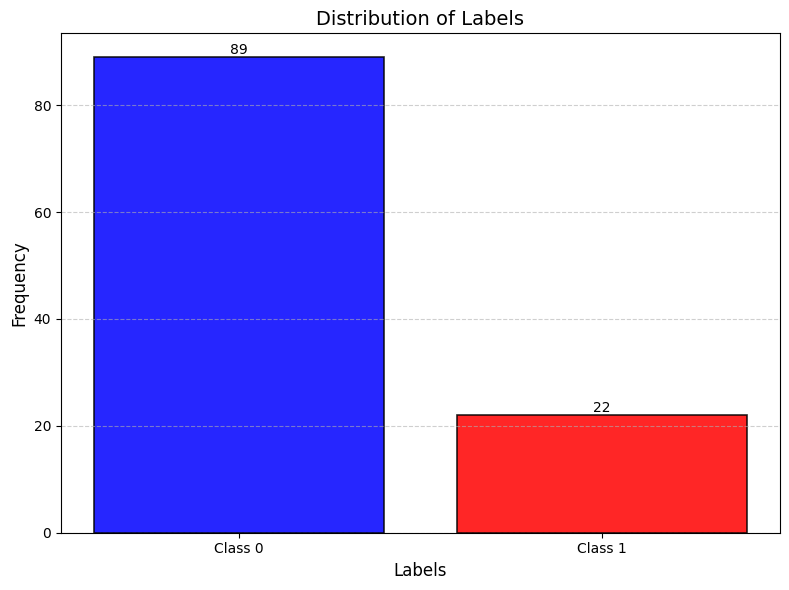

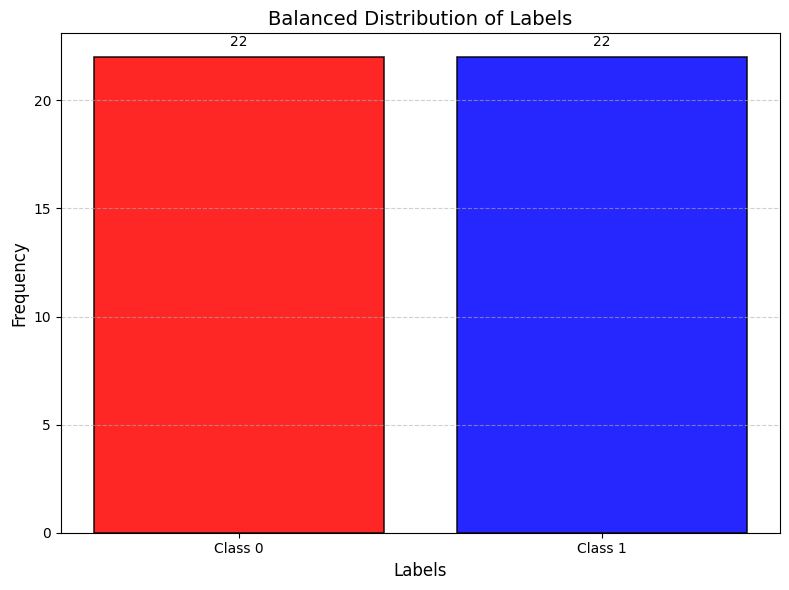

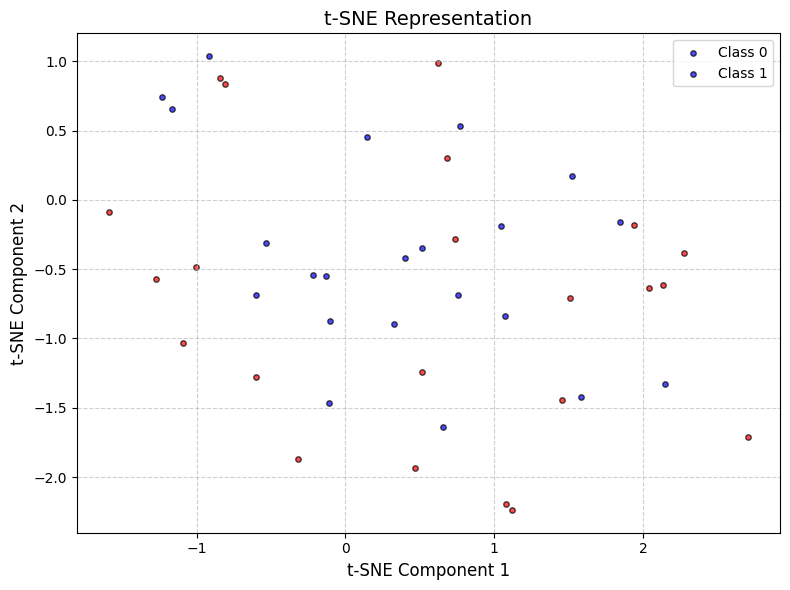

100%|██████████| 31/31 [00:01<00:00, 25.16it/s]

[LightGBM] [Info] Number of positive: 22, number of negative: 22
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000610 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12532
[LightGBM] [Info] Number of data points in the train set: 44, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

In [202]:
experiments(dataset_train, dataset_test, dataset_train_path)

## spanish-sentences-openai

In [70]:
dataset_train_path = "data/04-clustering/spanish-sentences-openai/clustring_embedding_train.pkl"
dataset_test_path = "data/04-clustering/spanish-sentences-openai/clustring_embedding_test.pkl"
dataset_train = read_pickle(dataset_train_path)
dataset_test = read_pickle(dataset_test_path)

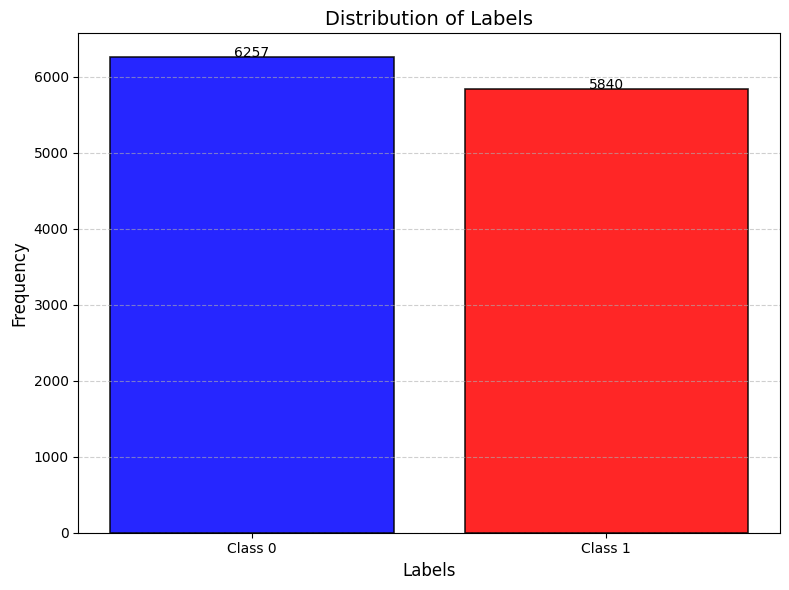

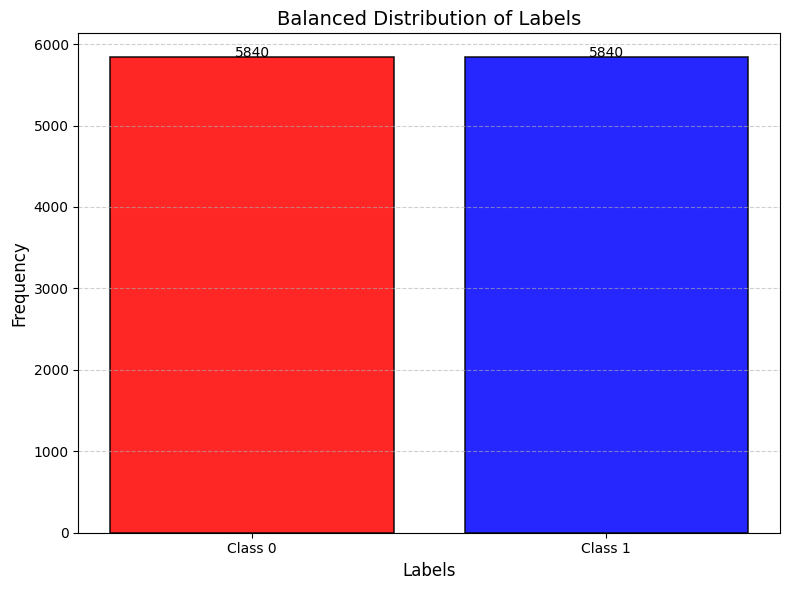

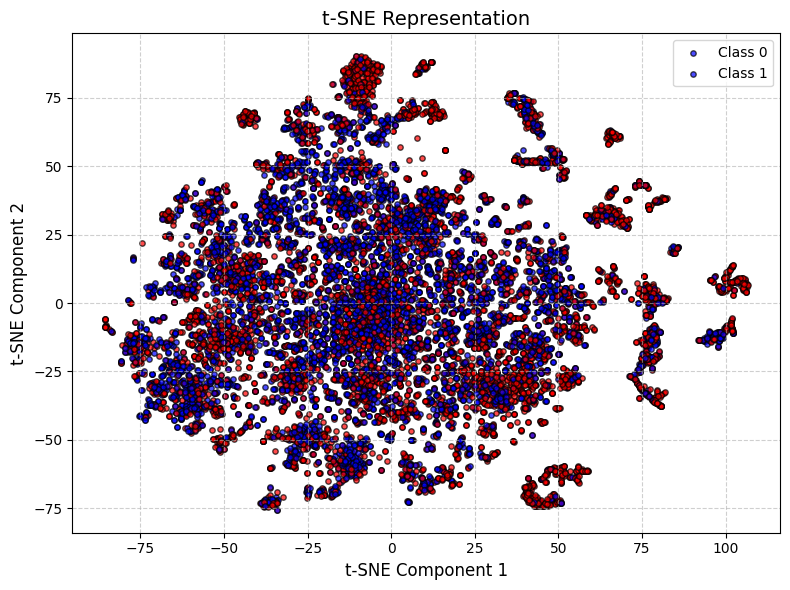

  3%|▎         | 1/31 [03:05<1:32:52, 185.76s/it]

In [ ]:
experiments(dataset_train, dataset_test, dataset_train_path)

## spanish-sentences-sentence-transformers

In [205]:
dataset_train_path = "data/04-clustering/spanish-sentences-sentence-transformers/clustring_embedding_train.pkl"
dataset_test_path = "data/04-clustering/spanish-sentences-sentence-transformers/clustring_embedding_test.pkl"

dataset_train = read_pickle(dataset_train_path)
dataset_test = read_pickle(dataset_test_path)

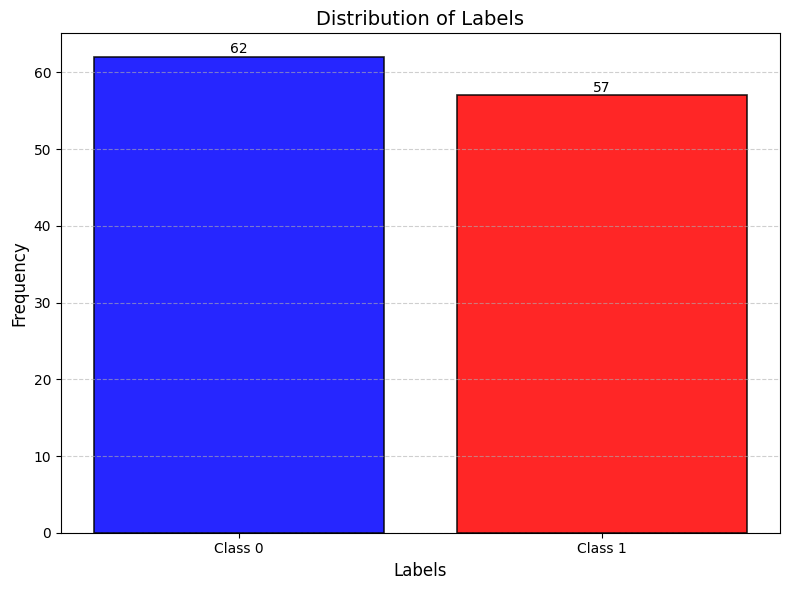

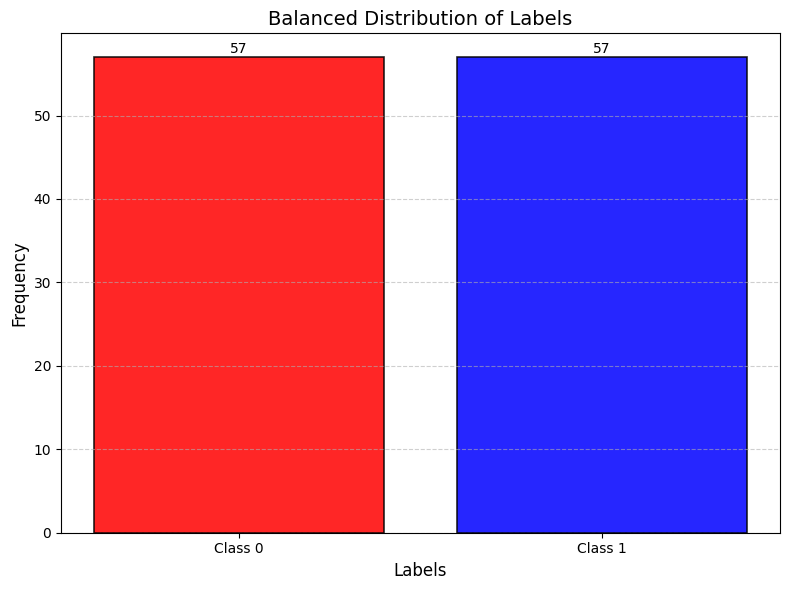

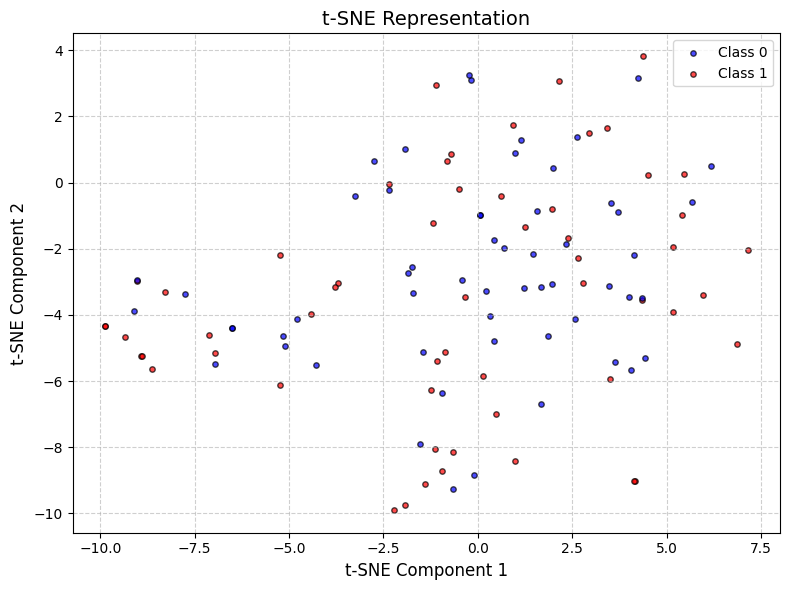

100%|██████████| 31/31 [00:02<00:00, 15.05it/s]

[LightGBM] [Info] Number of positive: 57, number of negative: 57
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000914 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 30442
[LightGBM] [Info] Number of data points in the train set: 114, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

In [206]:
experiments(dataset_train, dataset_test, dataset_train_path)